# Stereo Vision - Project Description

In this project you have to solve the stereo vision problem:
Given two images showing a scene from different points of view, the goal is to reconstruct 3D world coordinates for each point in the scene.
You will develop an algorithm, that has as a final output a point cloud, which you will be able to visualize.
The performance will be evaluated based on the dense distance map, i.e. the map of Z coordinates. Additionally the algorithm should output pixel-wise certainties, i.e. a value indicating how certain the prediction of that pixel is.

## One possible strategy

There certainly are more than one good solution to this problem. Here we briefly describe the steps of one possible implementation:

1. Determine all camera calibration parameters. As the parameters might change between scenes - this should be automated.
2. To invert the projection equations (see below) it is necessary to solve the correspondence problem, i.e. the knowledge of which pixel in the first view corresponds to a given pixel in the second view (and vice versa). The special camera setup in this exercise implies very simple *epipolar lines*. This simplifies the correspondece search. We can base this search on a similarity measure between two pixels. One possibility for a similarity measure is the Normalised Cross Correlation (NCC) of patches.
3. Triangulate the 3D world coordinates for every pixel pair in the left and right image.

## Camera Setup

* The camera setup of this exercise is shown in the figure below
* Througout the exercise it is save to assume $C' = (b, 0, 0)$
* Accordingly, the equations describing a projection of a point (X, Y, Z) onto the cameras are:
\begin{alignat*}{3}
  \text{Left:} \quad u_l &= f m_x \frac{X}{Z} + o_x \qquad & \text{Right:} \quad u_r &= f m_x \frac{X - b}{Z} + o_x \\
                     v_l &= f m_y \frac{Y}{Z} + o_y        &                     v_r &= f m_y \frac{Y}{Z} + o_y
\end{alignat*}
* Some internal parameters will be given to you. It is save to assume that left and right cameras share the same internal parameters.

![](https://drive.google.com/uc?export=view&id=174py9AwmAnNC5ACUKsIEn_tI69VdP2VN)

## Evaluation

You are given multiple scenes. Your task is to estimate the distance image for every scene, as well as a corresponding certainty score.
We define the distance image as the map of Z coordinates for every pixel in the __left__ camera image.

The score is based on the error of *inverse distance*. (Otherwise errors will necessarily be larger for objects further away). That is, we define $\tilde z = \frac{1}{z}$. Then the score consists of the following two terms:
1. The un-weighted $R^2$ score
\begin{align*}
  R^2 &= 1 - \frac{\sum_i \left|\tilde z^{(true)}_i - \tilde z^{(pred)}_i\right|^2}{\sum_i \left|\tilde z^{(true)}_i - \mu(\tilde z)\right|^2}
\end{align*}
2. The certainty weighted $R^2$ score
\begin{align*}
  R^2_w &= 1 - \frac{\sum_i w_i \left|\tilde z^{(true)}_i - \tilde z^{(pred)}_i\right|^2}{\sum_i w_i \left|\tilde z^{(true)}_i - \mu(\tilde z)\right|^2}
\end{align*}
3. The final score is the average of these two terms
\begin{align*}
  R^2_{final} = \frac{1}{2} \left(R^2 + R^2_w\right)
\end{align*}

Notes:
* __The expected units for $z$ are millimeters__
* __Speed is important__. If your code takes longer than 15s to run, a score of 0 is assigned.
* In the above expression $\mu(\tilde z) = \frac{1}{N} \sum_i \tilde z^{(true)}_i$ is the target mean.
* The $R^2$ score ranges from $(-\infty, +1]$ (Higher score is better)
* An algorithm predicting a constant distance image, where the constant is exactly the ground truths average has $R^2$ score of zero.
* If you do not want to implement a certainty score - return a constant value of $w_i = 1$. In that case $R^2 = R^2_w = R^2_{final}$
* In the score computation, extreme errors are clipped. See function `compute_score()` in `helper_funcs.py` for exact details.

# Stereo Vision - Implementation

## Task 0.0 - Import packages
TODO: Set the path to your exercise on Google Drive (i.e. set ex_path)

In [69]:
%load_ext autoreload
%autoreload 2

# Import some useful libraries
%matplotlib inline

import sys
import time
import shutil
from pathlib import Path

import numpy as np
import pandas as pd

from IPython.display import HTML

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
# First mount your drive
iacv_path = '/Users/joelflueckiger/Desktop/IACV/3/'

###############   TODO  ###############
# Set path to the exercise folder, e.g. MyDrive/iacv/ex3
ex_path = iacv_path

# Possibly append to PATH
if ex_path not in sys.path:
    sys.path.append(str(ex_path))

In [71]:
# Now we can import from the drive folder
from helper_funcs import (
    eval_scene,
    load_data,
    test_ncc,
    test_triangulation,
    plot_correlation,
    plot_point_cloud
)
import os
import sys

## Task 0.1 - Load Data

You are given a validation scene with ground truth for development.
The server has a second hidden scene, which will be used for evaluation.

The function `load_data` will return
 * `img_l`: The left camera image
 * `img_r`: The right camera image
 * `img_z`: Thr ground truth distance map
 * `calib_dict`: A dictionary with camera intrinsics. Units here are either `[px]` or `[mm]`
 * `calib_points`: A pandas dataframe that can be used for calibration

In [72]:
img_l, img_r, img_z, calib_dict, calib_points = load_data(os.path.join(ex_path, 'valid'))

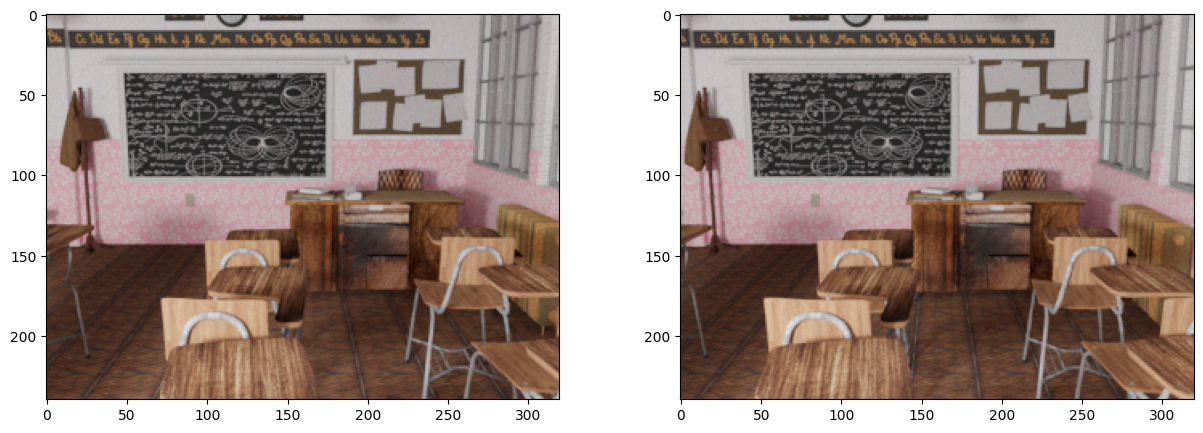

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].imshow(img_l)
axs[1].imshow(img_r)
plt.show()

One row of the dataframe `calib_points` corresponds to a physical point of the 3d scene. The dataframe has the following columns:
 * `ul [px]` and `vl [px]` ... (u, v) pixel coordinates of the point projected onto the left image. Units are number of pixel.
 * `ur [px]` and `vr [px]` ... (u, v) pixel coordinates of the point projected onto the right image. Units are number of pixel.
 * `X [mm]` and `Y [mm]` and `Z [mm]` ... (X, Y, Z) 3D coordinates of the point wrt global coordinate system (see figure). Units are millimeters.

In [74]:
# Some correspondences and world coords are provided to estiamte missing calibration parameters
calib_points

,ul [px],vl [px],ur [px],vr [px],X [mm],Y [mm],Z [mm]
0,313,107,305.465589,107,2030.683024,-172.541695,4645.353323
1,304,177,295.752147,177,1745.908841,691.088916,4243.528433
2,245,167,234.638961,167,820.381038,453.622456,3378.039569
3,95,111,89.563594,111,-1195.642849,-165.550548,6438.076878
4,222,18,216.527543,18,1132.946259,-1863.879330,6395.664367
5,9,24,3.769979,24,-2887.177873,-1835.556793,6692.134143
6,70,195,61.566776,195,-1067.207488,889.339573,4150.251342
7,153,136,142.278015,136,-65.286421,149.226105,3264.321047
8,254,48,248.609630,48,1743.850448,-1335.715237,6493.060180
9,84,45,78.534434,45,-1390.523978,-1372.227610,6403.728845


In [75]:
# Here are the provided camera parameters
# Note: Units here are either [px] or [mm]
for k, v in calib_dict.items():
    print(f"{k}: {v}")

height: 240.0
width: 320.0
aperture_h: 24.0
aperture_w: 32.0
o_x: 160.0
o_y: 120.0


## Task 1 - Calibration Parameteres

Unforunately some of the parameters, required for our task are missing. You will have to come up with a strategy to compute or estimate the following parameters:
* Pixel per millimeter $m_x$ and $m_y$ (internal parameters): These can be computed from other parameters in `calib_dict`.
* Focal lenght $f$ (internal paramter): Use provided calibration points to estimate.
* Base line $b$ (external paramter): Use provided calibration points to estimate. See introductory figure for definition.

You're task is to open the file `calibration.py` and
* Fill the formula for $m_x$ and $m_y$ in the function `compute_mx_my()`
* Implement the function `estimate_f_b()`

For the validation scene, the ground truth values are $f = 35\, [mm]$ and $b = 100\, [mm]$

In [76]:
from calibration import compute_mx_my, estimate_f_b

calib_dict['mx'], calib_dict['my'] = compute_mx_my(calib_dict)
f, b = estimate_f_b(calib_dict, calib_points)
print(f"Estimated f: {f} [mm] and b: {b} [mm]")

calib_dict['f'] = f
calib_dict['b'] = b

Estimated f: 35.00000000000001 [mm] and b: 100.00000000000068 [mm]


## Task 2 - Triangulation

Triangulation is the task of recovering the 3D world coordinates of a *physical point*, given it’s
coordinates in images from two views. Triangulation requires

1. Fully calibrated cameras, i.e. the internal and external camera parameters must be known.
   This was treated in task 1.
2. A solved correspondence problem, i.e. the knowledge of which pixel in the first view corresponds to a given pixel in the second view (and vice versa). We will treat correspondence search in Task 3.

Implement the function `triangulate(u_left, u_right, v, calib_dict)` within the file `stereo_3d_recon.py` to perform triangulation. See the functions `doc-string` for a description of the inputs and outputs.

In [77]:
# This test will fail if there is a mistake in the implementation of the first two tasks
from stereo_3d_recon import triangulate
test_triangulation(calib_dict, calib_points, triangulation_fn=triangulate)

Test succeeded :-)



## Task 3 - Correspondence Search via Normalized Cross-Correlation

### Description

Triangulation requires coordinates of a “physical” point in the images obtained from both the left and
the right cameras. Thus, for each point (pixel) in the left image, we want to find the corresponding
point in the right image. Given our special camera setup, we know that corresponding points in the
two images must have the same y coordinate. I.e. in this setup, epipolar lines correspond to rows in both images. This simplifies finding point correspondences.

Hence, we can process each horizontal line of the image separately. In order to identify
corresponding points we need a measure of similarity. In this exercise, we will use the normalized cross-correlation measure. The normalized cross-correlation of two points $p_R$ and $p_L$ (in the two views), is
defined via a pixel neighborhood as

\begin{align*}
  NCC(p_L,p_R) &= \frac{1} {|\Delta| \sigma_L \sigma_R }
  \sum_{dp_i\in\Delta} \left[I_L(p_L+dp_i)-\mu_L\right] \cdot \left[I_R(p_R+dp_i)-\mu_R\right] \\
  \mu_R &= \frac{1}{|\Delta|}\sum_{dp_i\in\Delta} I_R(p_R + dp_i) \\
  \sigma_R^2 &= \frac{1}{|\Delta|}\sum_{dp_i\in\Delta} \left[I_R(p_R + dp_i) - \mu_R\right]^2
\end{align*}

Here
* For $dp_i \in \Delta$ the index $p_L + dp_i$ indexes the i-th pixel in the neighborhood centered at $p_L$
* $|\Delta|$ notates the cardinality of the neighborhood (number of neighbors)
* $I_L$ and $I_R$ are left and right image respectively. $I_L(p)$ is the intensity of the left image at pixel p

### Problems with a naive implementation
A naive implementation of the NCC computation might look as follows:
Iterate (with a `for` loop) over every pixel in the first image.
Then iterate (nested `for` loop) over every possibly corresponding pixel in the second image
and compute NCC between the patches.

As you have seen in the Python tutorial Python loops are rather slow and the nested `for` loop approach is too inefficient! Often a significant speed-up can be achieved using libraries, such as NumPy.

As an example, the two approaches given below compute the mean over the last dimension of a 3-dimensional NumPy array.
Observe the difference in computation times.

In [88]:
# Initialize a random numpy array
a = np.random.rand(1000, 1000, 5)

def naive_mean_fn(arr):
    """ Compute mean over last dimension of a 3D array - Python Loop """
    arr_mean = np.zeros((1000, 1000))
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            arr_mean[i, j] = arr[i, j, :].mean()

def numpy_mean_fn(arr):
    """ Compute mean over last dimension of a 3D array - NumPy functions """
    return arr.mean(axis=2)

print("Without using NumPy functions")
%timeit naive_mean_fn(a)

print("Using NumPy functions")
%timeit numpy_mean_fn(a)

Without using NumPy functions


KeyboardInterrupt: 

### Efficient implementation - Patch extraction
With the right data structure and NumPy functions, a lot of the NCC computation can be parallelized,
i.e. we can find a much faster implementation!

A first step is to extract vectorized patches from both images.
You may have implemented this already in exercise 2, in which case you can simply copy the code in `extract_patches.py` from exercise 2.

Otherwise you can implement it now. Here we repeat the explanation previously given.

We now aim to extract all possible patches from the image.
That is for every pixel in the image we want to extract it's p x p neighborhood.

A naive implementation of this patch extraction will be way too slow!
There is a way to do this rather efficiently with the help of NumPy's roll() function.
The below image shows the principle for a 1D array.

Can you adapt & implement this idea for the case of 2D images?

What you have to do:
* Implement the function `extract_patches()`. The file `extract_patches.py` provides a starting point.
There is also a quick test below, to check the correct implementation of this patch extraction.

</br>
</br>

![](https://drive.google.com/uc?export=view&id=1tYMIkxfDTQ7tYnbfo5C6wUtfOrxRwIiO)

</br>
</br>



In [79]:
from extract_patches import check_patch_extraction, extract_patches
check_patch_extraction(extract_patches)

Dummy image of shape 4 x 5 x 1
[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 14 15]
 [16 17 18 19 20]]

Test completed successfully :)


### Efficient implementation - NCC as matrix multiplication
Assume you are given the vectorized & standardized (zero mean and unit variance) patches of possibly corresponding pixels in matrices $P_L$ and $P_R$.
Recall that in our setup corresponding pixels are found in corresponding rows of the image.

That is, if the image has width $W$ and the patches have size $C \times p \times p$ (for $C$ colour channels),
the matrix $P_L$ has $W$ rows and $Cp^2$ columns, such that each row holds a vectorized patch.
And equivalently for $P_R$.
Then we can use matrix multiplication for the NCC computation

\begin{align*}
  \frac{1}{\sigma_L \sigma_R} \sum_{dp_i\in\Delta} \left[I_L(p_L+dp_i)-\mu_L\right] \cdot \left[I_R(p_R+dp_i)-\mu_R\right] = [P_L * P_R^T]_{mn}
\end{align*}
where $m,n$ are indices corresponding to $p_L, p_R$ respectively.

The output will be of shape $W \times W$ and holds NCC for only a single row.
We can repeat this matrix multiplication for every row.
Luckily the NumPy function `matmul()` can parallelize the matrix multiplication for a batch of matrices.
We can make use of this to compute NCC for all rows in the images in parallel.

Implement the function `compute_ncc()` within `stereo_3d_recon.py`

### Test NCC (Dummy data)

The following gives you an idea, whether or not the `comupute_ncc` function is implemented correctly.

Expected Result: `[[[1.0, -0.5], [-0.5, 1.0]]]`

In [80]:
from stereo_3d_recon import compute_ncc
test_ncc(compute_ncc)

ERROR!!! Test of compute_ncc() failed :(

Here is the computed NCC
[[[ 9.  -4.5]
  [-4.5  9. ]]]


### Test NCC (Full image)

Compute NCC on a full image. Here is a qualitative reference image, what NCC image for column `100` should look like.
Note that timings can vary (+- 5s) depending on the machine you get assigned at the beginning of your CoLab session.

![](https://drive.google.com/uc?export=view&id=11dOmTn4P4v3fHJiDXD1QbBBrCjo7F4Hx)

NCC for full image took 11.83 seconds,


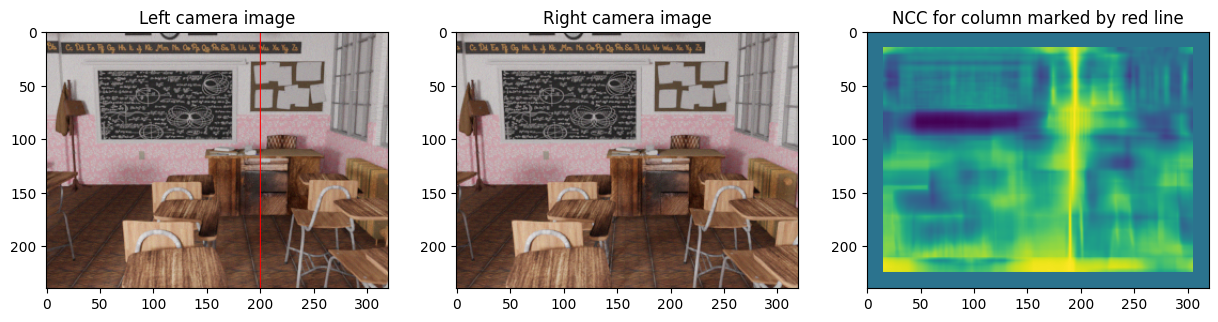

In [ ]:
# Plot the computed NCC for a particular column in the left image
t0 = time.time()
corr = compute_ncc(img_l, img_r, 8)
t1 = time.time()
print("NCC for full image took {:.2f} seconds,".format(t1 - t0))

column_index = 200
plot_correlation(img_l, img_r, corr, column_index)

## Task 4 - Stereo Reconstruction
Now it is time to put things together.
The method `recon_scene_3d()` of the `Stereo3dReconstructor` class is missing the implementation of the correspondence search and the uncertainty estimation. You can use NCC for both.

Hint:
 * For the correspondence search you may include physical limitations.
   In particular: It is impossible that our stereo camera records negative z values.
   (By definition such points are located behind the cameras).
   What does this imply for the correspondence search?

You can use the cell below to test your final implementation.
The IACV_BASELINE acchieves a score of 0.65 on the validation scene.

In [102]:
from stereo_3d_recon import Stereo3dReconstructor

# Instantiate reconstructor
reconstructor_3d = Stereo3dReconstructor(p=8, w_mode='uniform')

score, r2, r2_w, proc_time = eval_scene(os.path.join(ex_path, 'valid'), reconstructor_3d)
print(f"Average R2 score: {score} | Unweighted R2: {r2} | Weighted R2: {r2_w}")
print(f"Reconstruction took: {proc_time:.2f} seconds")

Average R2 score: 0.5469348614266053 | Unweighted R2: 0.534881584464171 | Weighted R2: 0.5589881383890396
Reconstruction took: 2.77 seconds


### Visualization of distsance map

In [84]:
reconstructor_3d = Stereo3dReconstructor()
points3d = reconstructor_3d.recon_scene_3d(img_l, img_r, calib_dict)

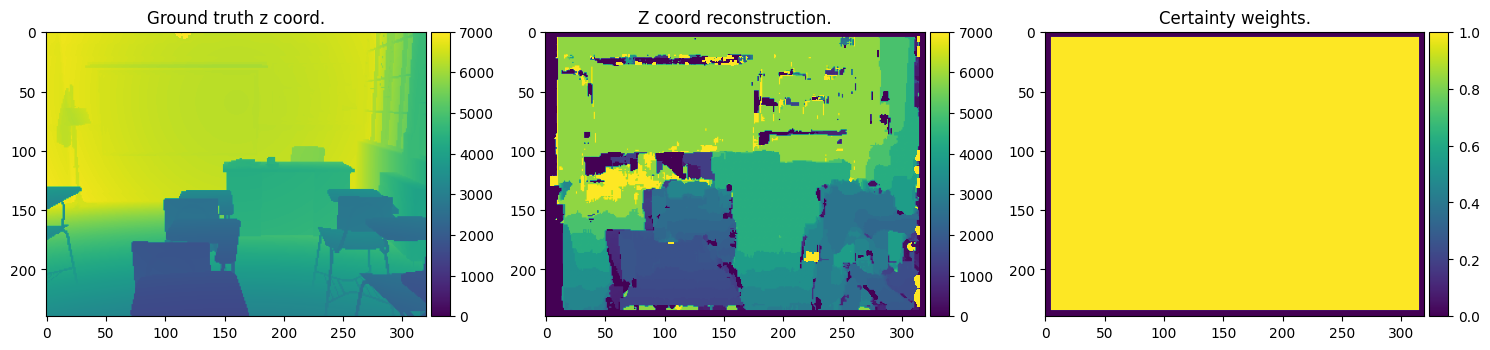

In [85]:
fig, axs = plt.subplots(1, 3, figsize=(15, 10))

# For valid scene use z_max of 7000
z_min = 0.
z_max = 7000.

# Ground truth
im = axs[0].imshow(img_z, vmin=z_min, vmax=z_max)
axs[0].set_title("Ground truth z coord.")

divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)

# Z - Reconstruction
im = axs[1].imshow(points3d[:, :, 2], vmin=z_min, vmax=z_max)
axs[1].set_title("Z coord reconstruction.")

divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)

# Certainty score
im = axs[2].imshow(points3d[:, :, 3])
axs[2].set_title("Certainty weights.")

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)

plt.tight_layout()
plt.show()

### Visualization of 3D point cloud

In [ ]:
fig = plot_point_cloud(img_l, img_r, points3d)
HTML(fig.to_html())

## Submission

After finishing your implementation, you can run the next cell to generate your submission.
Download the submission folder (**without renaming**) as a zip, and upload it to the evaluation server.

In [ ]:
out_dir = ex_path / 'submission'
out_dir.mkdir(exist_ok=True)

shutil.copyfile(str(ex_path / 'calibration.py'), str(out_dir / 'calibration.py'))
shutil.copyfile(str(ex_path / 'extract_patches.py'), str(out_dir / 'extract_patches.py'))
shutil.copyfile(str(ex_path / 'stereo_3d_recon.py'), str(out_dir / 'stereo_3d_recon.py'))